**Installs and Imports**

In [ ]:
%pip install mne
%pip install matplotlib
%pip install pymatreader
%pip install scipy

In [ ]:
%pip install FOOOF

In [ ]:
%pip install neurodsp

In [ ]:
%pip install python-dotenv

In [5]:
import os
from dotenv import load_dotenv
load_dotenv()

import numpy as np
import matplotlib
import mne
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
# the following import is required for matplotlib < 3.2:
from mpl_toolkits.mplot3d import Axes3D  # noqa

from neurodsp.spectral import compute_spectrum, trim_spectrum


# Import NeuroDSP plotting functions
from neurodsp.plts import (plot_time_series, plot_power_spectra, plot_bursts, plot_lagged_coherence)

from fooof import FOOOF
import os
import pandas as pd
import csv

import scipy
from scipy import stats
from collections import Counter
import statsmodels.api as sm

In [3]:
load_dotenv('PipelineVariables.env')
EEG_Directory=os.getenv('EEG_Directory')
EEG_Results_Directory=os.getenv('EEG_Results_Directory')

# **The Following functions are functions for pre-processing the data**

In [ ]:
%cd {EEG_Directory}

In [7]:
def segment_channels(raw): ## segments the data into desired channels
  channels_to_keep = ['E1', 'E2', 'E3', 'E4', 'E8', 'E9', 'E10', 'E15', 'E16', 'E18', 'E22', 'E23', 'E24', 'E25', 'E26', 'E27', 'E32', 'E33', 'E122', 'E123', 'E124']
  return raw.pick_channels(channels_to_keep)

In [8]:
def avgChannels(raw): ## averages channels into one evoked object of the data for the frontal lobe
  events = mne.find_events(raw, stim_channel = None)
  epochs = mne.Epochs(raw, events, event_id=None, tmin=0, tmax=10)
  evoked = epochs.average()
  return evoked

In [9]:
def computeFOOOF(raw):  ## FOOOF computations
  data, times = raw[:,:]
  freqs, powers = compute_spectrum(data[0], fs, method='welch', avg_type='median')
  freqs, powers = trim_spectrum(freqs, powers, [4, 28])
  return fm.report(freqs, powers, [4,28])

# **These blocks create necessary global variables for preprocessing, set our working directory, creating the FOOOF report, renaming files, and creating the PANDAS dataframe**

In [10]:

groups=dict(frontal = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])
fs = 250

In [11]:
#PANDAS Lists to be appended then made into Data frame
PersonalID = []
age = []
sex =[]

Aper_exp = []
Aper_exp = []
variance = []
error = []

ProcessedDataDict = {'ID': PersonalID, 'Age': age, 'Sex': sex,
'Aper_offset': Aper_offset, 'Aper_exp': Aper_exp, 'Variance': variance, 'Error': error}

PeakID = []
PeakIndex = []
CenterFrequency = []
PeakWidth = []
BandWidth = []

ProcessedPeaksDataDict = {'ID': PeakID, 'Age': age, 'Sex': sex, 'Peak_Number': PeakIndex , 'CF': CenterFrequency, 'PW': PeakWidth, 'BW': BandWidth}

failedIDs = []
redundantIDs = []
otherError = []

In [ ]:
%cd {EEG_Directory}

Completed so don't run once renamed

In [16]:

# for filename in os.listdir():
#   if filename.endswith('.fdt'):
#     os.rename(filename, filename[::-1][22::][::-1] + '.fdt')  #renames the files
#   elif filename.endswith('.set'):
#     os.rename(filename, filename[::-1][22::][::-1] + '.set')
# print('successfully completed')

# **Loop for preprocessing the files, creating FOOOF report, and saving the report to pandas.**

In [18]:
phenoDF = pd.read_csv('CorrectPhenotypesRaw.csv')  #phenotpypic data frame
phenoDF = phenoDF.set_index('EID')

fm = FOOOF()

Cell runs the analysis and saves values to be made into data frame

In [ ]:
for IDs, row in phenoDF.iterrows():
  if IDs not in PersonalID:
    try:
      raw = mne.io.read_raw_eeglab(input_fname = EEG_Directory + '\sub-' + IDs + '.set') #read the EEG file that was renamed earlier in format ID.set
      raw = segment_channels(raw)
      raw = mne.channels.combine_channels(raw, groups, method = 'median')  #channel averaging
      report = computeFOOOF(raw) #FOOOF object to break apart and save in pandas df



      ## Saving results to Lists to be made into data frame ##

      #from CSV

      ProcessedDataDict['ID'].append(IDs)
      ProcessedDataDict['Age'].append(phenoDF.loc[IDs,'Age'])
      ProcessedDataDict['Sex'].append(phenoDF.loc[IDs,'Sex'])
      
      #from FOOOF
      ProcessedDataDict['Aper_offset'].append(fm.aperiodic_params_[0])
      ProcessedDataDict['Aper_exp'].append(fm.aperiodic_params_[-1])
      ProcessedDataDict['Variance'].append(fm.r_squared_)
      ProcessedDataDict['Error'].append(fm.error_)

      PeakNum = 0 
      for peak in fm.peak_params_:  #appends the IDs and peak parameters into the lists
        ProcessedPeaksDataDict['ID'].append(IDs)
        ProcessedPeaksDataDict['Peak_Number'].append(PeakNum)
        ProcessedPeaksDataDict['CF'].append(peak[0])
        ProcessedPeaksDataDict['PW'].append(peak[1])
        ProcessedPeaksDataDict['BW'].append(peak[2])
        PeakNum +=1
    except FileNotFoundError:
      failedIDs.append(IDs)
      continue
    except Exception as e:
      errorLog = (IDs, e)
      otherError.append(errorLog)
  else:
    redundantIDs.append(IDs)



In [ ]:
ProcessedPeaksDataDict['Age'] = []
ProcessedPeaksDataDict['Sex'] = []
for uniqueID in ProcessedPeaksDataDict['ID']:
    ProcessedPeaksDataDict['Age'].append(phenoDF.loc[uniqueID,'Age'])
    ProcessedPeaksDataDict['Sex'].append(phenoDF.loc[uniqueID,'Sex'])
print(len(ProcessedPeaksDataDict['Age']))
print(len(ProcessedPeaksDataDict['Sex']))

In [30]:
processedDF = pd.DataFrame(ProcessedDataDict)
processedDF.to_csv('ProcessedAperData.csv', index = False)

In [44]:

#multilevel data frame for peaks
ProcessedPeaksDF = pd.DataFrame(ProcessedPeaksDataDict)
ProcessedPeaksDF.sort_values(['ID', 'Peak_Number']).set_index(['ID', 'Peak_Number'])
ProcessedPeaksDF.to_csv('ProcessedPerData.csv', index = False)

# **The Following Section is to Run Null Hyphothesis Testing**

In [199]:
%cd {EEG_Results_Directory}

[WinError 2] The system cannot find the file specified: '{EEG_Results_Directory}'
c:\Users\ishaa\Documents\PolygenceResearchProject\Adolescent-Prefrontal-Cortex-EEG-Analysis


In [200]:
aperDF = pd.read_csv('ProcessedAperData.csv')
aperDF = aperDF.set_index('ID')

perDF = pd.read_csv('ProcessedPerData.csv') #not indexed by ID because there are multiple ID entries per person

## *Data Frame for test results*

In [133]:
Test1 = [] #format 'independent var name v dependent var name'
AnovaStat = []
Anova_pValue = []

Test2 = []
LogRegression_coef = []
LogRegression_std_err = []
LogRegression_z = []
LogRegression_PZ = []

AnovaTable = pd.DataFrame({'Test Type' : Test1, 'F' : AnovaStat, 'P-Value' : Anova_pValue}).set_index('Test Type')
LogTable = pd.DataFrame({'Test Type' : Test2, 'coef' : LogRegression_coef, 'std Err' : LogRegression_std_err, 'z' : LogRegression_z, 'P > |z|' : LogRegression_PZ}).set_index('Test Type')




## *The following tests treat age in groups 5 - 8, 9 - 12, and 13 - 22 rounding age to the nearest year and tested with a series of One Way Anovas. The later tests use a series of logistic regression tests to test sex related interactions. The final section used One way anovas to test subgroups in age to look for relations beneath the original groups* 

### **One Way Anovas**

#### *Test for Age V. Offset |      (H0) Offset is independent of Age      |      (H1) Offset varies based on an individual's Age* | α = 0.01

In [134]:
#sort the data into age groups

youngest = []
middle = []
oldest = []

for ID, row in aperDF.iterrows():
        if (5 <= round(aperDF.loc[ID, 'Age']) <= 8):
            youngest.append(round(aperDF.loc[ID, 'Aper_offset'], 2))
        elif (9 <= round(aperDF.loc[ID, 'Age']) <= 12):
            middle.append(round(aperDF.loc[ID, 'Aper_offset'], 2))
        elif (13 <= round(aperDF.loc[ID, 'Age']) <= 22):
            oldest.append(round(aperDF.loc[ID, 'Aper_offset'], 2))
        else:   
            raise Exception('Participant Age is outside of expected range')

In [135]:
stat, pValue = scipy.stats.f_oneway(youngest, middle, oldest)

##### Result Entry

In [136]:
AnovaTable.loc['Age v Aperiodic Offset', 'F']= stat
AnovaTable.loc['Age v Aperiodic Offset', 'P-Value'] = pValue

In [137]:
AnovaTable  

,F,P-Value
Test Type,,
Age v Aperiodic Offset,197.853453,2.617024e-81


#### *Test for Age V. Aperiodic Exponent |      (H0) Exponent is independent of Age      |      (H1) Exponent varies based on an individual's Age* | α = 0.01

In [138]:
#sort the data into age groups

youngest = []
middle = []
oldest = []

for ID, row in aperDF.iterrows():
        if (5 <= round(aperDF.loc[ID, 'Age']) <= 8):
            youngest.append(round(aperDF.loc[ID, 'Aper_exp'], 2))
        elif (9 <= round(aperDF.loc[ID, 'Age']) <= 12):
            middle.append(round(aperDF.loc[ID, 'Aper_exp'], 2))
        elif (13 <= round(aperDF.loc[ID, 'Age']) <= 22):
            oldest.append(round(aperDF.loc[ID, 'Aper_exp'], 2))
        else:   
            raise Exception('Participant Age is outside of expected range')


In [139]:
stat, pValue = scipy.stats.f_oneway(youngest, middle, oldest)

##### Result Entry

In [140]:
AnovaTable.loc['Age v Aperiodic Exponent', 'F']= stat
AnovaTable.loc['Age v Aperiodic Exponent','P-Value'] = pValue

In [141]:
AnovaTable

,F,P-Value
Test Type,,
Age v Aperiodic Offset,197.853453,2.617024e-81
Age v Aperiodic Exponent,174.695752,2.173931e-72


#### Test for Age V. Center Frequency | (H0) Center Frequency is independent of Age | (H1) Center Frequency varies based on Age | α = 0.01

In [142]:
#sort the data into age groups

youngest = []
middle = []
oldest = []

for idx, row in perDF.iterrows():
    if (5 <= round(perDF.loc[idx, 'Age']) <= 8):
        youngest.append(perDF.loc[idx, 'CF'])
    elif (9 <= round(perDF.loc[idx, 'Age']) <= 12):
        middle.append(perDF.loc[idx, 'CF'])
    elif (13 <= round(perDF.loc[idx, 'Age']) <= 22):
        oldest.append(perDF.loc[idx, 'CF'])
    else:   
        raise Exception('Participant Age is outside of expected range')

In [143]:
stat, pValue = scipy.stats.f_oneway(youngest, middle, oldest)

##### Result Entry

In [144]:
AnovaTable.loc['Age v Center Frequency', 'F']= stat
AnovaTable.loc['Age v Center Frequency','P-Value'] = pValue

In [145]:
AnovaTable

,F,P-Value
Test Type,,
Age v Aperiodic Offset,197.853453,2.617024e-81
Age v Aperiodic Exponent,174.695752,2.173931e-72
Age v Center Frequency,34.396798,1.443094e-15


#### Test for Age V. Power | (H0) Power is independent of Age | (H1) Power varies based on Age | α = 0.01

In [146]:
#sort the data into age groups

youngest = []
middle = []
oldest = []

for idx, row in perDF.iterrows():
    if (5 <= round(perDF.loc[idx, 'Age']) <= 8):
        youngest.append(perDF.loc[idx, 'PW'])
    elif (9 <= round(perDF.loc[idx, 'Age']) <= 12):
        middle.append(perDF.loc[idx, 'PW'])
    elif (13 <= round(perDF.loc[idx, 'Age']) <= 22):
        oldest.append(perDF.loc[idx, 'PW'])
    else:   
        raise Exception('Participant Age is outside of expected range')

In [147]:
stat, pValue = scipy.stats.f_oneway(youngest, middle, oldest)

##### Result Entry

In [148]:
AnovaTable.loc['Age v Power', 'F']= stat
AnovaTable.loc['Age v Power','P-Value'] = pValue

In [149]:
AnovaTable

,F,P-Value
Test Type,,
Age v Aperiodic Offset,197.853453,2.617024e-81
Age v Aperiodic Exponent,174.695752,2.173931e-72
Age v Center Frequency,34.396798,1.443094e-15
Age v Power,1.708473,1.812436e-01


#### Test for Age V. Bandwidth | (H0) Bandwidth is independent of Age | (H1) Bandwidth varies based on Age | α = 0.01

In [150]:
#sort the data into age groups

youngest = []
middle = []
oldest = []

for idx, row in perDF.iterrows():
    if (5 <= round(perDF.loc[idx, 'Age']) <= 8):
        youngest.append(perDF.loc[idx, 'BW'])
    elif (9 <= round(perDF.loc[idx, 'Age']) <= 12):
        middle.append(perDF.loc[idx, 'BW'])
    elif (13 <= round(perDF.loc[idx, 'Age']) <= 22):
        oldest.append(perDF.loc[idx, 'BW'])
    else:   
        raise Exception('Participant Age is outside of expected range')

In [151]:
stat, pValue = scipy.stats.f_oneway(youngest, middle, oldest)

##### Result Entry

In [152]:
AnovaTable.loc['Age v Bandwidth', 'F']= stat
AnovaTable.loc['Age v Bandwidth','P-Value'] = pValue

In [153]:
AnovaTable

,F,P-Value
Test Type,,
Age v Aperiodic Offset,197.853453,2.617024e-81
Age v Aperiodic Exponent,174.695752,2.173931e-72
Age v Center Frequency,34.396798,1.443094e-15
Age v Power,1.708473,1.812436e-01
Age v Bandwidth,7.436208,5.957859e-04


## **The Following Section is to run models and analyze results of the fitting**

In [432]:
import seaborn as sns
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

### Age and Sex Offset Model Regression Model (OLS)

The Plot for this Aperiodic Offset 

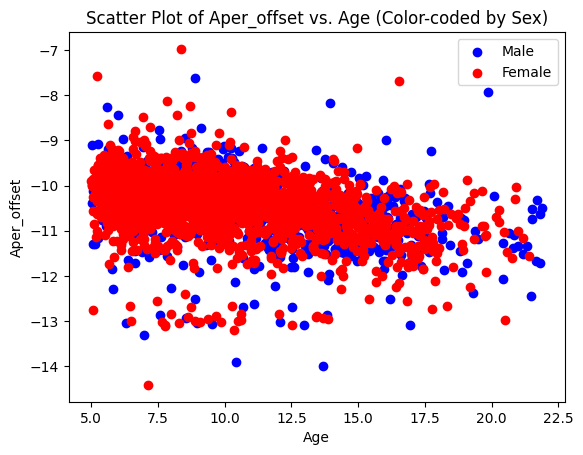

In [433]:
data = aperDF.drop(['Aper_exp','Variance','Error'], axis=1)
# Assuming you have the DataFrame named "data"
# Plot data points for males (Sex == 1) with blue color
plt.scatter(data[data['Sex'] == 1]['Age'], data[data['Sex'] == 1]['Aper_offset'], color='blue', label='Male')

# Plot data points for females (Sex == 0) with red color
plt.scatter(data[data['Sex'] == 0]['Age'], data[data['Sex'] == 0]['Aper_offset'], color='red', label='Female')

# Set labels and title
plt.xlabel('Age')
plt.ylabel('Aper_offset')
plt.title('Scatter Plot of Aper_offset vs. Age (Color-coded by Sex)')

# Add a legend to distinguish between male and female data points
plt.legend()

# Show the plot
plt.show()


#### Youngest Group (5 - 8)

##### Get the features/dependent variable for this age range then create the Test and Traing data (75% training | 25% testing | Seed 4)

In [434]:
x = aperDF.drop(['Aper_offset', 'Aper_exp', 'Variance', 'Error'], axis=1) #before seperating into the age group
y = aperDF['Aper_exp']

In [435]:
#seperate X DF for the age group
IDs_to_drop = []
for ID, row in aperDF.iterrows():
    if round(aperDF.loc[ID, 'Age']) >= 9:
        IDs_to_drop.append(ID)
x = x.drop(IDs_to_drop, axis=0)
#seperate Y DF for the age group
y = y.drop(IDs_to_drop, axis= 0)


In [436]:
training_x, testing_x, training_y, testing_y = train_test_split(x, y, test_size=0.25, random_state=4)

##### Fit OLS model using Age and Sex as features to predict Aperiodic Offset then analyze the results

In [437]:
X_with_intercept = sm.add_constant(training_x)
model_stats_youngest = sm.OLS(training_y, X_with_intercept).fit()
print(model_stats_youngest.summary())

predictions = model_stats_youngest.predict(sm.add_constant(testing_x))
absolute_err = np.abs(testing_y - predictions).mean()
mean_sq_err = np.square(testing_y - predictions).mean()

print('==============================================================================\n'+'absolute error : ', absolute_err)
print('mean_squared_error : ', mean_sq_err)
print('______________________________________________________________________')

                            OLS Regression Results                            
Dep. Variable:               Aper_exp   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.2718
Date:                Sun, 23 Jul 2023   Prob (F-statistic):              0.762
Time:                        23:36:41   Log-Likelihood:                -522.99
No. Observations:                 783   AIC:                             1052.
Df Residuals:                     780   BIC:                             1066.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.8984      0.126     15.052      0.0

In [438]:
dependent_variable_column = 'Aper_offset'
y.describe()

count    1045.000000
mean        1.996092
std         0.491310
min        -0.410438
25%         1.715921
50%         2.051360
75%         2.339143
max         3.613503
Name: Aper_exp, dtype: float64

Note the R - Squared, P-Values, Residual plot, and Errors compared to the standard deviation and spread of the dataset. The linear model/the current features are poor predictors, likely underfitting the data. Given the known relation of age and sex as predictors of Aperiodic components and certain research suggesting non linear trends, another model is appropriate. This relation is even clearer when looking at the plots.

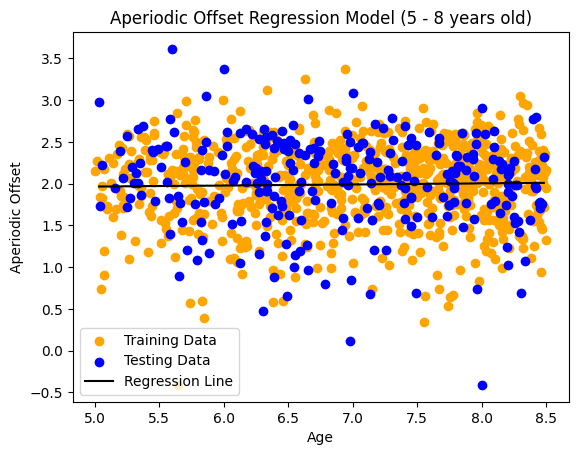

In [439]:
plt.scatter(training_x["Age"], training_y, color='orange', label='Training Data')
plt.scatter(testing_x["Age"], testing_y, color='blue', label='Testing Data')

sorted_indices = np.argsort(testing_x["Age"])
sorted_testing_x = testing_x.iloc[sorted_indices]
sorted_predictions = predictions[sorted_indices]

plt.xlabel('Age')
plt.ylabel('Aperiodic Offset')
plt.title('Aperiodic Offset Regression Model (5 - 8 years old)')
plt.plot(sorted_testing_x["Age"], sorted_predictions, color='k', label='Regression Line')

plt.legend()
plt.show()


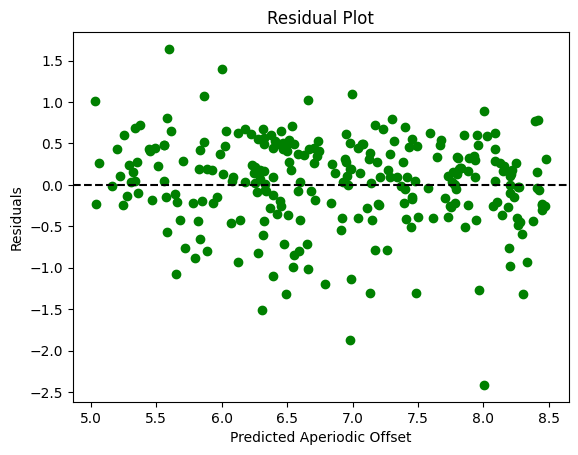

In [440]:
residuals = testing_y - predictions

plt.scatter(testing_x["Age"], residuals, color='green')
plt.xlabel('Predicted Aperiodic Offset')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='k', linestyle='--') 
plt.show()


### Middle Group (9 - 12)

#### Get the features/dependent variable for this age range then create the Test and Traing data (75% training | 25% testing | Seed 4)

In [441]:
x = aperDF.drop(['Aper_offset', 'Aper_exp', 'Variance', 'Error'], axis=1) #before seperating into the age group
y = aperDF['Aper_exp']

In [442]:
#seperate X DF for the age group
IDs_to_drop = []
for ID, row in aperDF.iterrows():
    if round(aperDF.loc[ID, 'Age']) <= 8 or round(aperDF.loc[ID, 'Age']) >= 13:
        IDs_to_drop.append(ID)
x = x.drop(IDs_to_drop, axis=0)
#seperate Y DF for the age group
y = y.drop(IDs_to_drop, axis= 0)


In [443]:
training_x, testing_x, training_y, testing_y = train_test_split(x, y, test_size=0.25, random_state=4)

#### Fit OLS model using Age and Sex as features to predict Aperiodic Offset then analyze the results

Note the R - Squared, P-Values, Residual plot, and Errors compared to the standard deviation and spread of the dataset. The model is slightly better in this larger age range and age is a stronger indicater, however, errors compared to the range and standard deviation indicate there is some additional features or non linear relations to be considered. 

In [444]:
X_with_intercept = sm.add_constant(training_x)
model_stats_middle = sm.OLS(training_y, X_with_intercept).fit()
print(model_stats_middle.summary())

predictions = model_stats_middle.predict(sm.add_constant(testing_x))
absolute_err = np.abs(testing_y - predictions).mean()
mean_sq_err = np.square(testing_y - predictions).mean()

print('==============================================================================\n'+'absolute error : ', absolute_err)
print('mean_squared_error : ', mean_sq_err)
print('______________________________________________________________________')

                            OLS Regression Results                            
Dep. Variable:               Aper_exp   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     4.727
Date:                Sun, 23 Jul 2023   Prob (F-statistic):            0.00909
Time:                        23:36:42   Log-Likelihood:                -629.92
No. Observations:                 865   AIC:                             1266.
Df Residuals:                     862   BIC:                             1280.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.3713      0.157     15.110      0.0

In [445]:
dependent_variable_column = 'Aper_offset'
y.describe()

count    1154.000000
mean        1.900133
std         0.496178
min        -1.508068
25%         1.638809
50%         1.950927
75%         2.218074
max         3.545709
Name: Aper_exp, dtype: float64

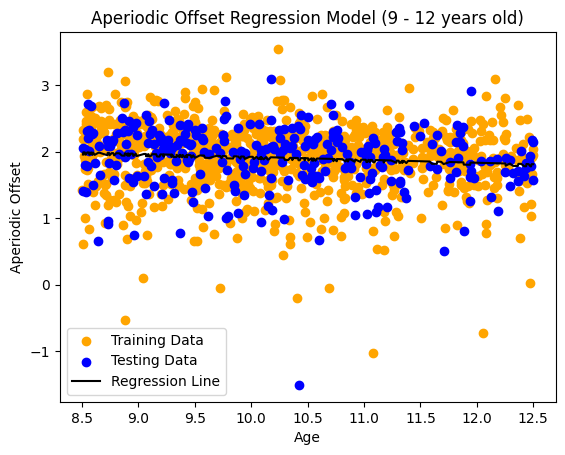

In [446]:
plt.scatter(training_x["Age"], training_y, color='orange', label='Training Data')
plt.scatter(testing_x["Age"], testing_y, color='blue', label='Testing Data')

sorted_indices = np.argsort(testing_x["Age"])
sorted_testing_x = testing_x.iloc[sorted_indices]
sorted_predictions = predictions[sorted_indices]

plt.xlabel('Age')
plt.ylabel('Aperiodic Offset')
plt.title('Aperiodic Offset Regression Model (9 - 12 years old)')
plt.plot(sorted_testing_x["Age"], sorted_predictions, color='k', label='Regression Line')

plt.legend()
plt.show()


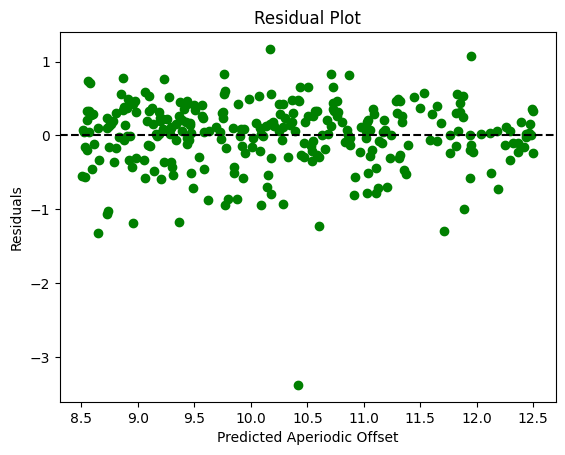

In [447]:
residuals = testing_y - predictions

plt.scatter(testing_x["Age"], residuals, color='green')
plt.xlabel('Predicted Aperiodic Offset')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='k', linestyle='--') 
plt.show()


### Oldest Group (13 - 22)

##### Get the features/dependent variable for this age range then create the Test and Traing data (75% training | 25% testing | Seed 4)

In [448]:
x = aperDF.drop(['Aper_offset', 'Aper_exp', 'Variance', 'Error'], axis=1) #before seperating into the age group
y = aperDF['Aper_exp']

In [449]:
#seperate X DF for the age group
IDs_to_drop = []
for ID, row in aperDF.iterrows():
    if round(aperDF.loc[ID, 'Age']) <= 12:
        IDs_to_drop.append(ID)
x = x.drop(IDs_to_drop, axis=0)
#seperate Y DF for the age group
y = y.drop(IDs_to_drop, axis= 0)


In [450]:
training_x, testing_x, training_y, testing_y = train_test_split(x, y, test_size=0.25, random_state=4)

#### Fit OLS model using Age and Sex as features to predict Aperiodic Offset then analyze the results

In [451]:
X_with_intercept = sm.add_constant(training_x)
model_stats_oldest = sm.OLS(training_y, X_with_intercept).fit()
print(model_stats_oldest.summary())

predictions = model_stats_oldest.predict(sm.add_constant(testing_x))
absolute_err = np.abs(testing_y - predictions).mean()
mean_sq_err = np.square(testing_y - predictions).mean()

print('==============================================================================\n'+'absolute error : ', absolute_err)
print('mean_squared_error : ', mean_sq_err)
print('______________________________________________________________________')

                            OLS Regression Results                            
Dep. Variable:               Aper_exp   R-squared:                       0.070
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     20.24
Date:                Sun, 23 Jul 2023   Prob (F-statistic):           3.33e-09
Time:                        23:36:43   Log-Likelihood:                -420.93
No. Observations:                 543   AIC:                             847.9
Df Residuals:                     540   BIC:                             860.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4969      0.167     14.995      0.0

In [452]:
dependent_variable_column = 'Aper_offset'
y.describe()

count    724.000000
mean       1.549375
std        0.553268
min       -1.884153
25%        1.250958
50%        1.626391
75%        1.932492
max        2.951022
Name: Aper_exp, dtype: float64

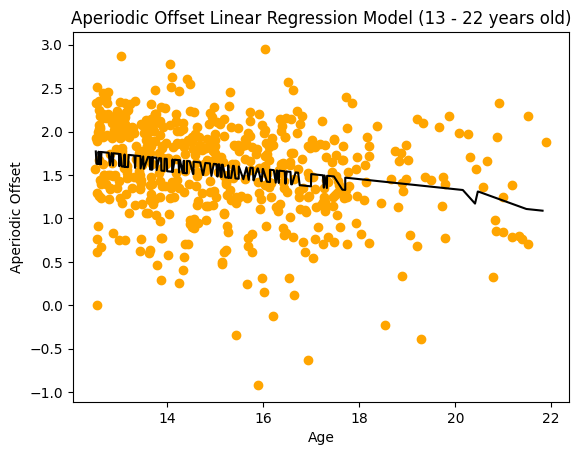

In [453]:
plt.scatter(training_x["Age"].tolist(), training_y, color='orange')

sorted_indices = np.argsort(testing_x["Age"])
sorted_testing_x = testing_x.iloc[sorted_indices]
sorted_predictions = predictions[sorted_indices]

plt.xlabel('Age')
plt.ylabel('Aperiodic Offset')
plt.title('Aperiodic Offset Linear Regression Model (13 - 22 years old)')
plt.plot(sorted_testing_x["Age"], sorted_predictions, color='k')

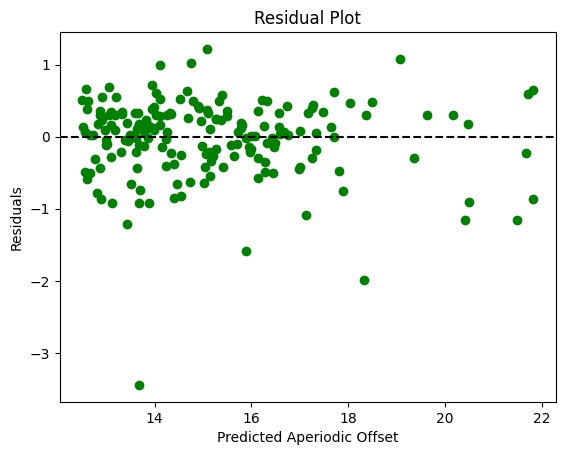

In [454]:
residuals = testing_y - predictions

plt.scatter(testing_x["Age"], residuals, color='green')
plt.xlabel('Predicted Aperiodic Offset')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='k', linestyle='--') 
plt.show()


#### **Full Plot**